# Анализ взаимодействия пользователя с карточками Яндекс.Дзен

Каждую неделю начинающие менеджеры Денис и Валерия задают вам одни и те же вопросы: 
- сколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек?
- как много карточек генерируют источники с разными темами?
- как соотносятся темы карточек и темы источников?

На шестую неделю работы вы решаете, что процесс пора автоматизировать. Для Дениса и Валерии нужно сделать дашборд. Дашборд будет основываться на пайплайне, который будет брать данные из таблицы, в которых хранятся сырые данные, трансформировать данные и укладывать их в агрегирующую таблицу. Пайплайн будет разработан для вас дата-инженерами.

**Цель проекта:**
- используя данные Яндекс.Дзена построить дашборд с метриками взаимодействия пользователей с карточками статей.

**Описание данных:**

Источники данных для дашборда: дата-инженеры подготовили агрегирующую таблицу `dash_visits`. 

Вот её структура:
- `record_id` — первичный ключ,
- `item_topic` — тема карточки,
- `source_topic` — тема источника,
- `age_segment` — возрастной сегмент,
- `dt` — дата и время,
- `visits` — количество событий.

Макет для создания дашборда:
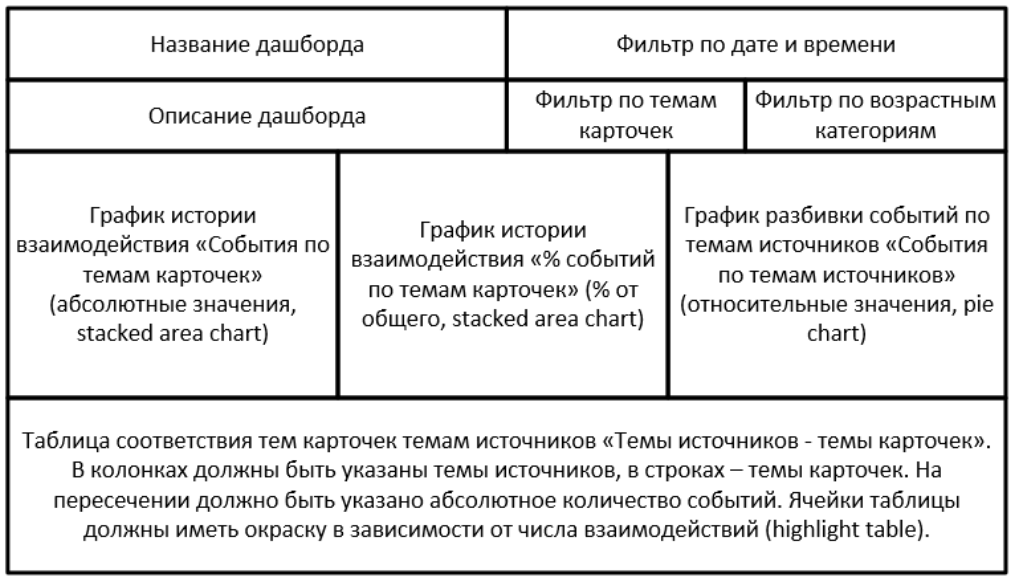

## Откроем файлы с данными и изучим общую информацию

In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
db_config = {'user': 'praktikum_student', # имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432, # порт подключения
            'db': 'data-analyst-zen-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string) 

In [3]:
query = '''
select * from dash_visits
'''

In [4]:
df = pd.io.sql.read_sql(query, con = engine)

Посмотрим на данные:

In [5]:
#напишем функцию для изучения датафрейма
def review(df):
    pd.options.display.max_colwidth = 130
    display(df),
    df.info(),
    print('*'*50),
    print(f'Количество явных дубликатов: {df.duplicated().sum()}'),
    print(f'Доля явных дубликатов: {(df.duplicated().sum() / df.shape[0]):.2%}'), 
    print('*'*50),
    print('Статистическая информация о столбцах:'),
    print(df.describe())

In [6]:
review(df)

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27
...,...,...,...,...,...,...
30740,1071337,Юмор,Финансы,36-40,2019-09-24 18:57:00,2
30741,1071338,Юмор,Финансы,36-40,2019-09-24 19:00:00,1
30742,1071339,Юмор,Финансы,41-45,2019-09-24 18:54:00,1
30743,1071340,Юмор,Финансы,41-45,2019-09-24 18:56:00,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   record_id     30745 non-null  int64         
 1   item_topic    30745 non-null  object        
 2   source_topic  30745 non-null  object        
 3   age_segment   30745 non-null  object        
 4   dt            30745 non-null  datetime64[ns]
 5   visits        30745 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.4+ MB
**************************************************
Количество явных дубликатов: 0
Доля явных дубликатов: 0.00%
**************************************************
Статистическая информация о столбцах:
          record_id        visits
count  3.074500e+04  30745.000000
mean   1.055969e+06     10.089673
std    8.875461e+03     19.727601
min    1.040597e+06      1.000000
25%    1.048283e+06      1.000000
50%    1.055969e+06

In [7]:
print(f'Минимальная дата исследования: {df.dt.min()}')
print(f'Максимальная дата исследования: {df.dt.max()}')

Минимальная дата исследования: 2019-09-24 18:28:00
Максимальная дата исследования: 2019-09-24 19:00:00


<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- 30745 строк и 6 столбцов для исследования;
- явных дубликатов нет;
- пропуски не обнаружены;
- данные за 24 сентября 2019г, с 18:28 по 19:00.

##  Дашборд

Датафрейм в порядке, предобработка не требуется, выгрузим таблицу в файл `dash_visits.csv`:

In [8]:
df.to_csv('dash_visits.csv', index=False, encoding='utf-8')

В Tableau Public на основе файла `dash_visits.csv`  сформируем дашборд в соответствии с макетом:

https://public.tableau.com/app/profile/din.gaffarov/viz/yandex_dzen_16862199530830/Dashboard1

## Презентация исследования

Презентация: https://disk.yandex.ru/i/X_EVddYuycaQUg